In [43]:
import acl
import numpy as np
from PIL import Image, ImageDraw
from acl_sample import Sample
import struct
from constant import NPY_BYTE, ACL_MEMCPY_DEVICE_TO_HOST, ACL_MEM_MALLOC_NORMAL_ONLY, ACL_MEMCPY_HOST_TO_DEVICE
from postprocessing import postprocess_boxes
import cv2
import matplotlib.pyplot as plt

In [44]:
with open("data/coco.names") as fd:
    coco_labels = fd.readlines()

coco_labels = [i[:-1] for i in coco_labels][1:]

In [51]:
device_id = 0
input_size = 416
model_path = "./model/yolov3_caffe.om"
img_dict = {"path": "./data/dog.jpg", "dtype": np.uint8}

In [52]:
sample = Sample(device_id,
                model_path,
                input_size,
                input_size)

[Sample] init resource stage:
[Sample] init resource stage success
[Model] class Model init resource stage:
[Model] create model output dataset:
[Model] create model output dataset success
model input size 2
input  0
model input dims ({'name': 'data', 'dimCount': 4, 'dims': [1, 416, 416, 3]}, 0)
model input datatype 4
input  1
model input dims ({'name': 'img_info', 'dimCount': 2, 'dims': [1, 4]}, 0)
model input datatype 0
model output size 2
output  0
model output dims ({'name': 'detection_out3:0:box_out', 'dimCount': 2, 'dims': [1, 6144]}, 0)
model output datatype 0
output  1
model output dims ({'name': 'detection_out3:1:box_out_num', 'dimCount': 2, 'dims': [1, 8]}, 0)
model output datatype 3
[Model] class Model init resource stage success
[Model] class Model release source success
[Dvpp] class Dvpp exist success
[Sample] class Sample release source success


In [ ]:
# %timeit -n 100 -r 10
boxes = sample.forward(img_dict)

In [54]:
img = Image.open(img_dict["path"])

In [55]:
img1 = ImageDraw.Draw(img)
for i in range(boxes["num_detections"]):
    box = boxes[i]
    img1.rectangle([box["x1"], box["y1"], box["x2"], box["y2"]], outline ="red", width=2)
    print(box["x1"], box["y1"], box["x2"], box["y2"], box["detection_scores"], box["detection_classes"], coco_labels[int(box["detection_classes"])])

155.25 119.8125 567.0 440.0 0.99609375 1.0 bicycle
475.5 86.0625 689.0 170.75 0.89404296875 7.0 truck
127.5 226.125 315.5 535.0 0.98828125 16.0 dog


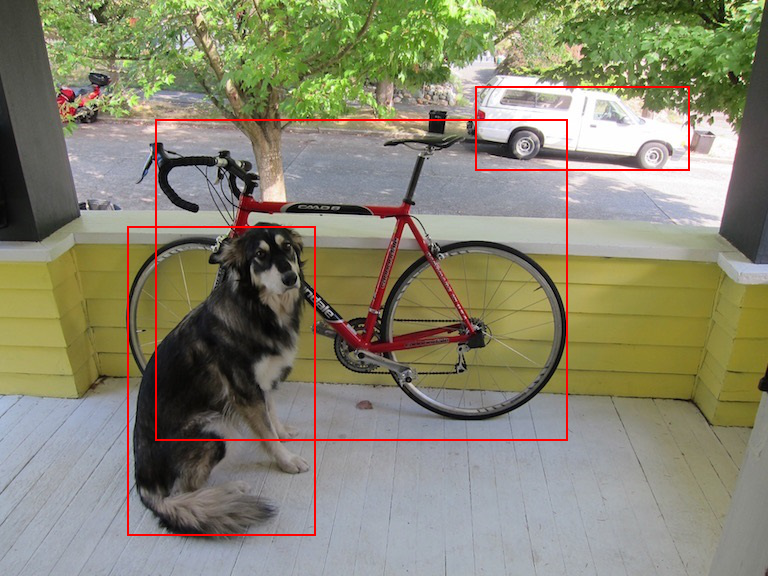

In [56]:
img